In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

from custom_models import get_cell_based_tiny_net
from custom_search_cells import NAS201SearchCell as SearchCell
from xautodl.models.cell_searchs.genotypes import Structure

# NB201
from nas_201_api import NASBench201API as API

import scipy.stats as stats

2022-11-03 05:59:35.150653: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200', help="Folder to save checkpoints and log.")
# parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--arch_nas_dataset", type=str, default=None, help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

66857
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=66857, save_dir='./cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 66857
save_dir         : ./cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
# if xargs.arch_nas_dataset is None:
api = None
# else:
#     api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    w_scheduler.load_state_dict(checkpoint["w_scheduler"])
    w_optimizer.load_state_dict(checkpoint["w_optimizer"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
./MY.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=50, current::epoch=0, iter=0.00, type=cosine, T-max=50, eta-min=0.001)
criterion   : CrossEntropyLoss(

In [5]:
def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        # accuracy
        network.train()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        
        # sensitivity
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        sensitivity = kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        # robustness
        original_weights = deepcopy(network.state_dict())
        for m in network.modules():
            if isinstance(m, SearchCell):
                for p in m.parameters():
                    p.add_(torch.randn_like(p) * p.std()*0.3)
            
        _, noisy_logits = network(inputs)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        network.load_state_dict(original_weights)
                
        return acc.item(), confidence.item(), sensitivity.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
    inputs, targets = inputs[:64], targets[:64] # smaller batches
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.025)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.025/3)
    for i in range(3):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
    small_step_dict = deepcopy(network.state_dict())
    scores = []
    for key in large_step_dict.keys():
        if ('weight' in key) and (original_dict[key].dim()==4):
            if (original_dict[key] != large_step_dict[key]).sum():
                large_step = large_step_dict[key] - original_dict[key]
                small_step = small_step_dict[key] - original_dict[key]
                co, ci, kh, kw = large_step.size()
                large_step = large_step.view(co, -1)
                small_step = small_step.view(co, -1)
                score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
                score = score.mean().item() * 100 # in percent
                scores.append(score)
    if len(scores)==0:
        step_sim = 100
        raise RuntimeError
    else:
        step_sim = np.mean(scores)
    
    # resume
    network.load_state_dict(original_dict)
            
    return step_sim

In [6]:
# start training
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)

################# initialize
cells = []
for m in network.modules():
    if isinstance(m, SearchCell):
        cells.append(m)
num_cells = len(cells)
print("total number of nodes:{}".format(num_cells*xargs.max_nodes))
        
op_names = deepcopy(cells[0].op_names)
op_names_wo_none = deepcopy(op_names)
if "none" in op_names_wo_none:
    op_names_wo_none.remove("none")

genotypes = []
for i in range(1, xargs.max_nodes):
    xlist = []
    for j in range(i):
        node_str = "{:}<-{:}".format(i, j)
        if i-j==1:
            op_name = "skip_connect"
        else:
            op_name = "none"
        xlist.append((op_name, j))
    genotypes.append(tuple(xlist))
init_arch = Structure(genotypes)

for c in cells:
    c.arch_cache = init_arch

### gen possible connections of a target node
possible_connections = {}
for target_node_idx in range(1,xargs.max_nodes):
    possible_connections[target_node_idx] = list()
    xlists = []
    for src_node in range(target_node_idx):
        node_str = "{:}<-{:}".format(target_node_idx, src_node)
        # select possible ops
#         if target_node_idx - src_node == 1:
#             op_names_tmp = op_names_wo_none
#         else:
#             op_names_tmp = op_names
        op_names_tmp = op_names
            
        if len(xlists) == 0: # initial iteration
            for op_name in op_names_tmp:
                xlists.append([(op_name, src_node)])
        else:
            new_xlists = []
            for op_name in op_names_tmp:
                for xlist in xlists:
                    new_xlist = deepcopy(xlist)
                    new_xlist.append((op_name, src_node))
                    new_xlists.append(new_xlist)
            xlists = new_xlists
    for xlist in xlists:
        selected_ops = []
        for l in xlist:
            selected_ops.append(l[0])
        if sum(np.array(selected_ops) == "none") == len(selected_ops):
            continue
        possible_connections[target_node_idx].append(tuple(xlist))
    print("target_node:{}".format(target_node_idx), len(possible_connections[target_node_idx]))
        
### train while generating random architectures by mutating connections of a target node

for arch_loop in range(1):
    for target_cell_idx in range(num_cells):
        target_cell = cells[target_cell_idx]
        print("\n\n Searching with a cell #{}".format(target_cell_idx))
        ####
        for m in target_cell.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()
        ####
        ## training
        for ep in range(10):
            ###
            genotypes = []
            for n in range(1, xargs.max_nodes):
                genotypes.append(random.choice(possible_connections[n]))
            arch = Structure(genotypes)
            target_cell.arch_cache = arch
#             arch = target_cell.random_genotype(True)
            ###
            data_time, batch_time = AverageMeter(), AverageMeter()
            base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
            network.train()
            end = time.time()
            print_freq = 200
            for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(search_loader):
                ######### forward/backward/optim
                base_targets = base_targets.cuda(non_blocking=True)
                arch_targets = arch_targets.cuda(non_blocking=True)
                # measure data loading time
                data_time.update(time.time() - end)
                w_optimizer.zero_grad()
                _, logits = network(base_inputs)
                base_loss = criterion(logits, base_targets)
                base_loss.backward()
                nn.utils.clip_grad_norm_(network.parameters(), 5)
                w_optimizer.step()

                ######### logging
                base_prec1, base_prec5 = obtain_accuracy(logits.data, base_targets.data, topk=(1, 5))
                base_losses.update(base_loss.item(), base_inputs.size(0))
                base_top1.update(base_prec1.item(), base_inputs.size(0))
                base_top5.update(base_prec5.item(), base_inputs.size(0))
                batch_time.update(time.time() - end)
                end = time.time()
                if step % print_freq == 0 or step + 1 == len(search_loader):
                    Sstr = ("*Train* "+ time_string()+" Ep:{:} [{:03d}/{:03d}]".format(ep, step, len(search_loader)))
                    Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(batch_time=batch_time, data_time=data_time)
                    Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(loss=base_losses, top1=base_top1, top5=base_top5)
                    logger.log(Sstr + " " + Tstr + " " + Wstr)

            logger.log("Ep:{:} ends : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(ep, base_losses.avg, base_top1.avg, base_top5.avg))
        ## evaluation
        network.train()
        archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = [], [], [], [], [], []
        loader_iter = iter(valid_loader)
        for search_iter in range(200):
            ###### random gen
            genotypes = []
            for n in range(1, xargs.max_nodes):
                genotypes.append(random.choice(possible_connections[n]))
            arch = Structure(genotypes)
            target_cell.arch_cache = arch
#             arch = target_cell.random_genotype(True)
            ###### measure metrics
            try:
                inputs, targets = next(loader_iter)
            except:
                loader_iter = iter(valid_loader)
                inputs, targets = next(loader_iter)
            inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
            valid_acc, confidence, sensitivity, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
            step_sim = step_sim_metric(network, criterion, inputs, targets)
            archs.append(arch)
            metric_accs.append(valid_acc)
            metric_confidences.append(confidence)
            metric_sensitivities.append(sensitivity)
            metric_robustnesses.append(robustness)
            metric_step_sims.append(step_sim)
        rank_accs, rank_confidences, rank_sensitivities, rank_robustnesses, rank_step_sims = stats.rankdata(metric_accs), stats.rankdata(metric_confidences), stats.rankdata(metric_sensitivities), stats.rankdata(metric_robustnesses), stats.rankdata(metric_step_sims)
        l = len(rank_accs)
        rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_robustnesses/l)+np.log(rank_step_sims/l)
#             rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_step_sims/l)
        best_idx = np.argmax(rank_agg)
        best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx], metric_step_sims[best_idx]
        logger.log("Found best op for target cell:{}".format(target_cell_idx))
        logger.log(": {:} with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}, step_sim={:.3f}".format(best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim))
        target_cell.arch_cache = best_arch
            
best_archs = []
for c in cells:
    best_archs.append(c.arch_cache)
    
torch.save({"model":search_model.state_dict(), "best_archs":best_archs}, os.path.join(xargs.save_dir, "output.pth"))

for m in search_model.modules():
    if isinstance(m, SearchCell):
        logger.log(m.arch_cache)

logger.close()

total number of nodes:60
target_node:1 4
target_node:2 24
target_node:3 124


 Searching with a cell #0
*Train* [2022-11-03 05:59:41] Ep:0 [000/391] Time 2.48 (2.48) Data 0.13 (0.13) Base [Loss 2.285 (2.285)  Prec@1 12.50 (12.50) Prec@5 54.69 (54.69)]
*Train* [2022-11-03 06:00:00] Ep:0 [200/391] Time 0.18 (0.11) Data 0.00 (0.00) Base [Loss 1.688 (1.825)  Prec@1 31.25 (30.60) Prec@5 87.50 (84.78)]
*Train* [2022-11-03 06:00:18] Ep:0 [390/391] Time 0.07 (0.10) Data 0.00 (0.00) Base [Loss 1.514 (1.697)  Prec@1 42.50 (35.99) Prec@5 95.00 (87.80)]
Ep:0 ends : loss=1.70, accuracy@1=35.99%, accuracy@5=87.80%
*Train* [2022-11-03 06:00:18] Ep:1 [000/391] Time 0.23 (0.23) Data 0.15 (0.15) Base [Loss 2.227 (2.227)  Prec@1 28.12 (28.12) Prec@5 73.44 (73.44)]
*Train* [2022-11-03 06:00:42] Ep:1 [200/391] Time 0.07 (0.12) Data 0.00 (0.00) Base [Loss 1.458 (1.489)  Prec@1 46.88 (45.75) Prec@5 92.19 (91.78)]
*Train* [2022-11-03 06:01:04] Ep:1 [390/391] Time 0.13 (0.12) Data 0.00 (0.00) Base [Loss 1.355 

*Train* [2022-11-03 06:13:22] Ep:5 [390/391] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.702 (0.779)  Prec@1 70.00 (72.80) Prec@5 100.00 (98.08)]
Ep:5 ends : loss=0.78, accuracy@1=72.80%, accuracy@5=98.08%
*Train* [2022-11-03 06:13:23] Ep:6 [000/391] Time 0.26 (0.26) Data 0.18 (0.18) Base [Loss 1.590 (1.590)  Prec@1 43.75 (43.75) Prec@5 90.62 (90.62)]
*Train* [2022-11-03 06:13:39] Ep:6 [200/391] Time 0.13 (0.08) Data 0.00 (0.00) Base [Loss 0.820 (0.800)  Prec@1 70.31 (71.77) Prec@5 98.44 (98.20)]
*Train* [2022-11-03 06:14:04] Ep:6 [390/391] Time 0.13 (0.11) Data 0.00 (0.00) Base [Loss 0.744 (0.784)  Prec@1 77.50 (72.46) Prec@5 100.00 (98.22)]
Ep:6 ends : loss=0.78, accuracy@1=72.46%, accuracy@5=98.22%
*Train* [2022-11-03 06:14:04] Ep:7 [000/391] Time 0.33 (0.33) Data 0.18 (0.18) Base [Loss 3.596 (3.596)  Prec@1 15.62 (15.62) Prec@5 57.81 (57.81)]
*Train* [2022-11-03 06:14:23] Ep:7 [200/391] Time 0.15 (0.10) Data 0.00 (0.00) Base [Loss 0.895 (0.846)  Prec@1 62.50 (70.65) Prec@5 100.0

*Train* [2022-11-03 06:29:16] Ep:1 [000/391] Time 0.28 (0.28) Data 0.20 (0.20) Base [Loss 1.238 (1.238)  Prec@1 62.50 (62.50) Prec@5 96.88 (96.88)]
*Train* [2022-11-03 06:29:32] Ep:1 [200/391] Time 0.08 (0.08) Data 0.00 (0.00) Base [Loss 0.719 (0.648)  Prec@1 73.44 (77.57) Prec@5 100.00 (98.77)]
*Train* [2022-11-03 06:29:55] Ep:1 [390/391] Time 0.12 (0.10) Data 0.00 (0.00) Base [Loss 1.082 (0.652)  Prec@1 65.00 (77.43) Prec@5 95.00 (98.68)]
Ep:1 ends : loss=0.65, accuracy@1=77.43%, accuracy@5=98.68%
*Train* [2022-11-03 06:29:56] Ep:2 [000/391] Time 0.30 (0.30) Data 0.16 (0.16) Base [Loss 1.180 (1.180)  Prec@1 54.69 (54.69) Prec@5 96.88 (96.88)]
*Train* [2022-11-03 06:30:17] Ep:2 [200/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.598 (0.645)  Prec@1 73.44 (77.78) Prec@5 100.00 (98.67)]
*Train* [2022-11-03 06:30:38] Ep:2 [390/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.824 (0.646)  Prec@1 77.50 (77.79) Prec@5 92.50 (98.70)]
Ep:2 ends : loss=0.65, accuracy@1=77.79%, accuracy

*Train* [2022-11-03 06:43:38] Ep:7 [000/391] Time 0.28 (0.28) Data 0.17 (0.17) Base [Loss 0.665 (0.665)  Prec@1 75.00 (75.00) Prec@5 98.44 (98.44)]
*Train* [2022-11-03 06:44:02] Ep:7 [200/391] Time 0.07 (0.12) Data 0.00 (0.00) Base [Loss 0.612 (0.601)  Prec@1 76.56 (79.50) Prec@5 98.44 (98.78)]
*Train* [2022-11-03 06:44:25] Ep:7 [390/391] Time 0.13 (0.12) Data 0.00 (0.00) Base [Loss 0.707 (0.600)  Prec@1 72.50 (79.47) Prec@5 100.00 (98.82)]
Ep:7 ends : loss=0.60, accuracy@1=79.47%, accuracy@5=98.82%
*Train* [2022-11-03 06:44:26] Ep:8 [000/391] Time 0.28 (0.28) Data 0.18 (0.18) Base [Loss 0.826 (0.826)  Prec@1 67.19 (67.19) Prec@5 93.75 (93.75)]
*Train* [2022-11-03 06:44:49] Ep:8 [200/391] Time 0.12 (0.12) Data 0.00 (0.00) Base [Loss 0.635 (0.601)  Prec@1 78.12 (78.89) Prec@5 100.00 (99.11)]
*Train* [2022-11-03 06:45:08] Ep:8 [390/391] Time 0.09 (0.11) Data 0.00 (0.00) Base [Loss 0.880 (0.601)  Prec@1 70.00 (79.21) Prec@5 100.00 (98.96)]
Ep:8 ends : loss=0.60, accuracy@1=79.21%, accurac

*Train* [2022-11-03 07:00:46] Ep:2 [200/391] Time 0.09 (0.11) Data 0.00 (0.00) Base [Loss 0.656 (0.624)  Prec@1 81.25 (78.53) Prec@5 96.88 (98.76)]
*Train* [2022-11-03 07:01:07] Ep:2 [390/391] Time 0.13 (0.11) Data 0.00 (0.00) Base [Loss 0.698 (0.611)  Prec@1 75.00 (78.98) Prec@5 100.00 (98.76)]
Ep:2 ends : loss=0.61, accuracy@1=78.98%, accuracy@5=98.76%
*Train* [2022-11-03 07:01:07] Ep:3 [000/391] Time 0.25 (0.25) Data 0.16 (0.16) Base [Loss 0.916 (0.916)  Prec@1 70.31 (70.31) Prec@5 98.44 (98.44)]
*Train* [2022-11-03 07:01:31] Ep:3 [200/391] Time 0.12 (0.12) Data 0.00 (0.00) Base [Loss 0.522 (0.627)  Prec@1 79.69 (78.35) Prec@5 100.00 (98.79)]
*Train* [2022-11-03 07:01:55] Ep:3 [390/391] Time 0.09 (0.12) Data 0.00 (0.00) Base [Loss 0.563 (0.615)  Prec@1 80.00 (78.92) Prec@5 100.00 (98.81)]
Ep:3 ends : loss=0.62, accuracy@1=78.92%, accuracy@5=98.81%
*Train* [2022-11-03 07:01:55] Ep:4 [000/391] Time 0.27 (0.27) Data 0.17 (0.17) Base [Loss 1.050 (1.050)  Prec@1 59.38 (59.38) Prec@5 98.4

*Train* [2022-11-03 07:15:20] Ep:8 [000/391] Time 0.28 (0.28) Data 0.19 (0.19) Base [Loss 0.577 (0.577)  Prec@1 79.69 (79.69) Prec@5 100.00 (100.00)]
*Train* [2022-11-03 07:15:41] Ep:8 [200/391] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.388 (0.560)  Prec@1 85.94 (80.69) Prec@5 100.00 (99.11)]
*Train* [2022-11-03 07:16:03] Ep:8 [390/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.866 (0.548)  Prec@1 70.00 (81.14) Prec@5 97.50 (99.10)]
Ep:8 ends : loss=0.55, accuracy@1=81.14%, accuracy@5=99.10%
*Train* [2022-11-03 07:16:03] Ep:9 [000/391] Time 0.28 (0.28) Data 0.18 (0.18) Base [Loss 0.698 (0.698)  Prec@1 78.12 (78.12) Prec@5 96.88 (96.88)]
*Train* [2022-11-03 07:16:27] Ep:9 [200/391] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.568 (0.550)  Prec@1 84.38 (80.87) Prec@5 98.44 (99.03)]
*Train* [2022-11-03 07:16:47] Ep:9 [390/391] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.524 (0.538)  Prec@1 80.00 (81.44) Prec@5 97.50 (99.07)]
Ep:9 ends : loss=0.54, accuracy@1=81.44%, accurac

*Train* [2022-11-03 07:33:19] Ep:3 [200/391] Time 0.14 (0.11) Data 0.00 (0.00) Base [Loss 0.378 (0.534)  Prec@1 87.50 (82.13) Prec@5 100.00 (99.09)]
*Train* [2022-11-03 07:33:42] Ep:3 [390/391] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.468 (0.543)  Prec@1 85.00 (81.59) Prec@5 100.00 (99.10)]
Ep:3 ends : loss=0.54, accuracy@1=81.59%, accuracy@5=99.10%
*Train* [2022-11-03 07:33:42] Ep:4 [000/391] Time 0.35 (0.35) Data 0.19 (0.19) Base [Loss 2.132 (2.132)  Prec@1 37.50 (37.50) Prec@5 82.81 (82.81)]
*Train* [2022-11-03 07:34:06] Ep:4 [200/391] Time 0.13 (0.12) Data 0.00 (0.00) Base [Loss 0.743 (0.629)  Prec@1 81.25 (78.12) Prec@5 96.88 (98.72)]
*Train* [2022-11-03 07:34:28] Ep:4 [390/391] Time 0.14 (0.12) Data 0.00 (0.00) Base [Loss 0.566 (0.593)  Prec@1 82.50 (79.50) Prec@5 100.00 (98.92)]
Ep:4 ends : loss=0.59, accuracy@1=79.50%, accuracy@5=98.92%
*Train* [2022-11-03 07:34:28] Ep:5 [000/391] Time 0.28 (0.28) Data 0.19 (0.19) Base [Loss 0.616 (0.616)  Prec@1 79.69 (79.69) Prec@5 100.

*Train* [2022-11-03 07:48:04] Ep:9 [000/391] Time 0.30 (0.30) Data 0.20 (0.20) Base [Loss 0.409 (0.409)  Prec@1 85.94 (85.94) Prec@5 100.00 (100.00)]
*Train* [2022-11-03 07:48:27] Ep:9 [200/391] Time 0.13 (0.11) Data 0.00 (0.00) Base [Loss 0.404 (0.462)  Prec@1 84.38 (84.06) Prec@5 100.00 (99.34)]
*Train* [2022-11-03 07:48:50] Ep:9 [390/391] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.592 (0.480)  Prec@1 70.00 (83.32) Prec@5 100.00 (99.29)]
Ep:9 ends : loss=0.48, accuracy@1=83.32%, accuracy@5=99.29%
Found best op for target cell:10
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|none~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|) with accuracy=76.95%, confidence=68.461%, sensitivity=0.154, robustness=-0.091, step_sim=99.761


 Searching with a cell #11
*Train* [2022-11-03 07:51:50] Ep:0 [000/391] Time 0.29 (0.29) Data 0.19 (0.19) Base [Loss 0.553 (0.553)  Prec@1 81.25 (81.25) Prec@5 100.00 (100.00)]
*Train* [2022-11-03 07:52:13] Ep:0 [200/391] Time 0.13 (0.12) Data 0.0

*Train* [2022-11-03 08:06:21] Ep:4 [200/391] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.531 (0.453)  Prec@1 84.38 (84.60) Prec@5 100.00 (99.28)]
*Train* [2022-11-03 08:06:44] Ep:4 [390/391] Time 0.13 (0.12) Data 0.00 (0.00) Base [Loss 0.574 (0.462)  Prec@1 82.50 (84.24) Prec@5 100.00 (99.31)]
Ep:4 ends : loss=0.46, accuracy@1=84.24%, accuracy@5=99.31%
*Train* [2022-11-03 08:06:44] Ep:5 [000/391] Time 0.39 (0.39) Data 0.20 (0.20) Base [Loss 0.531 (0.531)  Prec@1 84.38 (84.38) Prec@5 96.88 (96.88)]
*Train* [2022-11-03 08:07:09] Ep:5 [200/391] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.414 (0.468)  Prec@1 81.25 (84.13) Prec@5 100.00 (99.19)]
*Train* [2022-11-03 08:07:29] Ep:5 [390/391] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.594 (0.471)  Prec@1 80.00 (83.83) Prec@5 100.00 (99.23)]
Ep:5 ends : loss=0.47, accuracy@1=83.83%, accuracy@5=99.23%
*Train* [2022-11-03 08:07:30] Ep:6 [000/391] Time 0.28 (0.28) Data 0.18 (0.18) Base [Loss 1.594 (1.594)  Prec@1 40.62 (40.62) Prec@5 95.

Found best op for target cell:13
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|skip_connect~2|) with accuracy=76.95%, confidence=68.852%, sensitivity=0.159, robustness=-0.080, step_sim=99.787


 Searching with a cell #14
*Train* [2022-11-03 08:24:39] Ep:0 [000/391] Time 0.30 (0.30) Data 0.20 (0.20) Base [Loss 0.674 (0.674)  Prec@1 76.56 (76.56) Prec@5 100.00 (100.00)]
*Train* [2022-11-03 08:25:04] Ep:0 [200/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.548 (0.435)  Prec@1 79.69 (85.30) Prec@5 98.44 (99.29)]
*Train* [2022-11-03 08:25:30] Ep:0 [390/391] Time 0.15 (0.13) Data 0.00 (0.00) Base [Loss 0.610 (0.437)  Prec@1 77.50 (85.27) Prec@5 100.00 (99.31)]
Ep:0 ends : loss=0.44, accuracy@1=85.27%, accuracy@5=99.31%
*Train* [2022-11-03 08:25:30] Ep:1 [000/391] Time 0.29 (0.29) Data 0.19 (0.19) Base [Loss 2.821 (2.821)  Prec@1 4.69 (4.69) Prec@5 50.00 (50.00)]
*Train* [2022-11-03 08:25:57] Ep:1 [200/391] Time 0.18 (0.14) Data 

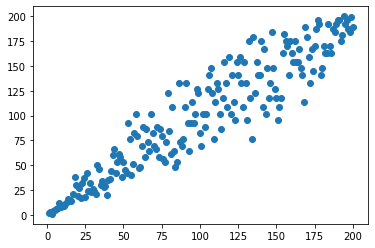

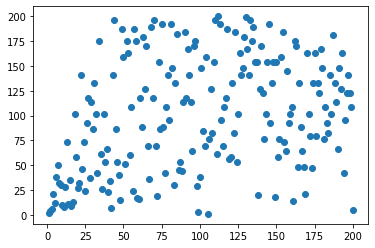

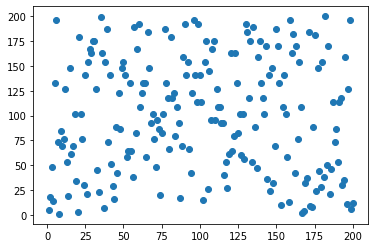

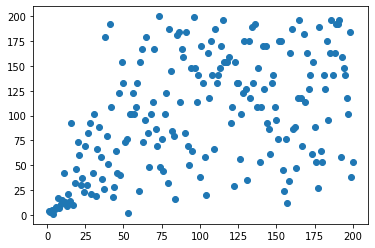

In [7]:
import matplotlib.pyplot as plt

plt.scatter(rank_confidences,rank_accs)
plt.show()

plt.scatter(rank_sensitivities,rank_accs)
plt.show()

plt.scatter(rank_robustnesses,rank_accs)
plt.show()

plt.scatter(rank_step_sims,rank_accs)
plt.show()

# Train a found model

In [8]:
trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
print(args)
args.save_dir = os.path.join(xargs.save_dir, "train")
print(args)

Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=66857, save_dir='./cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=66857, save_dir='./cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [9]:
print(config)

Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))


In [10]:
logger = prepare_logger(args)

# cifar_train_config_path = "./MY.config"
cifar_train_config_path = "../configs/nas-benchmark/CIFAR.config"
###
train_data, test_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(cifar_train_config_path, {"class_num": class_num, "xshape": xshape}, logger)

train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

# search_loader, _, valid_loader = get_nas_search_loaders(train_data,
#                                                         valid_data,
#                                                         xargs.dataset,
#                                                         "../configs/nas-benchmark/",
#                                                         (config.batch_size, config.batch_size),
#                                                         xargs.workers)
logger.log("||||||| {:10s} ||||||| Train-Loader-Num={:}, Test-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(train_loader), len(test_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": True, # true for eval
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

### load
# trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
# search_model.load_state_dict(trained_output['model'], strict=False)
best_archs = trained_output['best_archs']
i=0
for m in search_model.modules():
    if isinstance(m, SearchCell):
        m.arch_cache = best_archs[i]
        i += 1
for m in network.modules():
    if isinstance(m, SearchCell):
        print(m.arch_cache)
###

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))

network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)

start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Main Function with logger : Logger(dir=cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 66857
save_dir         : ./cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None
Files already downloaded and verified
Files already downloaded and verified
../configs/nas-benchmark/CIFAR.config
Configure(scheduler='cos', eta_min=0.0, epochs=200, warmup=0, optim='SG

In [11]:
# def search_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
#     data_time, batch_time = AverageMeter(), AverageMeter()
#     base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
#     network.train()
#     end = time.time()
#     for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(
#         xloader
#     ):
#         scheduler.update(None, 1.0 * step / len(xloader))
#         base_targets = base_targets.cuda(non_blocking=True)
#         arch_targets = arch_targets.cuda(non_blocking=True)
#         # measure data loading time
#         data_time.update(time.time() - end)

#         w_optimizer.zero_grad()
#         _, logits = network(base_inputs)
#         base_loss = criterion(logits, base_targets)
#         base_loss.backward()
#         nn.utils.clip_grad_norm_(network.parameters(), 5)
#         w_optimizer.step()
#         # record
#         base_prec1, base_prec5 = obtain_accuracy(
#             logits.data, base_targets.data, topk=(1, 5)
#         )
#         base_losses.update(base_loss.item(), base_inputs.size(0))
#         base_top1.update(base_prec1.item(), base_inputs.size(0))
#         base_top5.update(base_prec5.item(), base_inputs.size(0))

#         # measure elapsed time
#         batch_time.update(time.time() - end)
#         end = time.time()

#         if step % print_freq == 0 or step + 1 == len(xloader):
#             Sstr = (
#                 "*SEARCH* "
#                 + time_string()
#                 + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
#             )
#             Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
#                 batch_time=batch_time, data_time=data_time
#             )
#             Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
#                 loss=base_losses, top1=base_top1, top5=base_top5
#             )
#             logger.log(Sstr + " " + Tstr + " " + Wstr)
#     return base_losses.avg, base_top1.avg, base_top5.avg

def train_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
    data_time, batch_time = AverageMeter(), AverageMeter()
    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.train()
    end = time.time()
    for step, (base_inputs, base_targets) in enumerate(
        xloader
    ):
        scheduler.update(None, 1.0 * step / len(xloader))
        base_targets = base_targets.cuda(non_blocking=True)
        # measure data loading time
        data_time.update(time.time() - end)

        w_optimizer.zero_grad()
        _, logits = network(base_inputs)
        base_loss = criterion(logits, base_targets)
        base_loss.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 5)
        w_optimizer.step()
        # record
        base_prec1, base_prec5 = obtain_accuracy(
            logits.data, base_targets.data, topk=(1, 5)
        )
        base_losses.update(base_loss.item(), base_inputs.size(0))
        base_top1.update(base_prec1.item(), base_inputs.size(0))
        base_top5.update(base_prec5.item(), base_inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % print_freq == 0 or step + 1 == len(xloader):
            Sstr = (
                "*SEARCH* "
                + time_string()
                + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
            )
            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
                batch_time=batch_time, data_time=data_time
            )
            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
                loss=base_losses, top1=base_top1, top5=base_top5
            )
            logger.log(Sstr + " " + Tstr + " " + Wstr)
    return base_losses.avg, base_top1.avg, base_top5.avg

def valid_func_one_arch(xloader, network, criterion):
    data_time, batch_time = AverageMeter(), AverageMeter()
    arch_losses, arch_top1, arch_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.eval()
    end = time.time()
    with torch.no_grad():
        for step, (arch_inputs, arch_targets) in enumerate(xloader):
            arch_targets = arch_targets.cuda(non_blocking=True)
            # measure data loading time
            data_time.update(time.time() - end)
            # prediction

#             network.module.random_genotype_per_cell(True)
            _, logits = network(arch_inputs)
            arch_loss = criterion(logits, arch_targets)
            # record
            arch_prec1, arch_prec5 = obtain_accuracy(
                logits.data, arch_targets.data, topk=(1, 5)
            )
            arch_losses.update(arch_loss.item(), arch_inputs.size(0))
            arch_top1.update(arch_prec1.item(), arch_inputs.size(0))
            arch_top5.update(arch_prec5.item(), arch_inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    return arch_losses.avg, arch_top1.avg, arch_top5.avg

In [ ]:
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)
for epoch in range(0, total_epoch):
    w_scheduler.update(epoch, 0.0)
    need_time = "Time Left: {:}".format(
        convert_secs2time(epoch_time.val * (total_epoch - epoch), True)
    )
    epoch_str = "{:03d}-{:03d}".format(epoch, total_epoch)
    logger.log(
        "\n[Search the {:}-th epoch] {:}, LR={:}".format(
            epoch_str, need_time, min(w_scheduler.get_lr())
        )
    )

    # selected_arch = search_find_best(valid_loader, network, criterion, xargs.select_num)
    search_w_loss, search_w_top1, search_w_top5 = train_func_one_arch(
        train_loader,
        network,
        criterion,
        w_scheduler,
        w_optimizer,
        epoch_str,
        xargs.print_freq,
        logger,
    )
    search_time.update(time.time() - start_time)
    logger.log(
        "[{:}] searching : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%, time-cost={:.1f} s".format(
            epoch_str, search_w_loss, search_w_top1, search_w_top5, search_time.sum
        )
    )
    valid_a_loss, valid_a_top1, valid_a_top5 = valid_func_one_arch(
        test_loader, network, criterion
    )
    logger.log(
        "[{:}] evaluate  : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(
            epoch_str, valid_a_loss, valid_a_top1, valid_a_top5
        )
    )
    
    # check the best accuracy
    valid_accuracies[epoch] = valid_a_top1
    if valid_a_top1 > valid_accuracies["best"]:
        valid_accuracies["best"] = valid_a_top1
        find_best = True
    else:
        find_best = False

    # save checkpoint
    save_path = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xargs),
            "search_model": search_model.state_dict(),
            "w_optimizer": w_optimizer.state_dict(),
            "w_scheduler": w_scheduler.state_dict(),
            "genotypes": genotypes,
            "valid_accuracies": valid_accuracies,
        },
        model_base_path,
        logger,
    )
    last_info = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(args),
            "last_checkpoint": save_path,
        },
        logger.path("info"),
        logger,
    )
    if find_best:
        logger.log(
            "<<<--->>> The {:}-th epoch : find the highest validation accuracy : {:.2f}%.".format(
                epoch_str, valid_a_top1
            )
        )
        copy_checkpoint(model_base_path, model_best_path, logger)
    if api is not None:
        logger.log("{:}".format(api.query_by_arch(genotypes[epoch], "200")))
    # measure elapsed time
    epoch_time.update(time.time() - start_time)
    start_time = time.time()

logger.close()


[Search the 000-200-th epoch] Time Left: [00:00:00], LR=0.1
*SEARCH* [2022-11-03 08:36:47] [000-200][000/196] Time 0.54 (0.54) Data 0.28 (0.28) Base [Loss 2.370 (2.370)  Prec@1 8.59 (8.59) Prec@5 43.36 (43.36)]
*SEARCH* [2022-11-03 08:37:19] [000-200][195/196] Time 0.16 (0.17) Data 0.00 (0.00) Base [Loss 1.276 (1.588)  Prec@1 56.25 (40.75) Prec@5 95.00 (89.23)]
[000-200] searching : loss=1.59, accuracy@1=40.75%, accuracy@5=89.23%, time-cost=32.5 s
[000-200] evaluate  : loss=1.96, accuracy@1=33.81%, accuracy@5=88.34%
save checkpoint into cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/checkpoint/seed-66857-basic.pth
save checkpoint into cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/seed-66857-last-info.pth
<<<--->>> The 000-200-th epoch : find the highest validation accuracy : 33.81%.
copy the file from cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/checkpoint/seed-66857-basic.pth into cell_level-arch_loop-reset_cell_params-loop1

*SEARCH* [2022-11-03 08:40:55] [006-200][195/196] Time 0.10 (0.16) Data 0.00 (0.00) Base [Loss 1.021 (0.719)  Prec@1 66.25 (74.94) Prec@5 97.50 (98.52)]
[006-200] searching : loss=0.72, accuracy@1=74.94%, accuracy@5=98.52%, time-cost=225.2 s
[006-200] evaluate  : loss=1.28, accuracy@1=59.87%, accuracy@5=96.57%
Find cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/checkpoint/seed-66857-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/checkpoint/seed-66857-basic.pth
Find cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/seed-66857-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/seed-66857-last-info.pth
<<<--->>> The 006-200-th epoch : find the highest validation accuracy : 59.87%.
Find cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/checkpoint/seed-66857-best.

*SEARCH* [2022-11-03 08:44:23] [013-200][000/196] Time 0.47 (0.47) Data 0.28 (0.28) Base [Loss 0.633 (0.633)  Prec@1 75.00 (75.00) Prec@5 98.83 (98.83)]
*SEARCH* [2022-11-03 08:44:53] [013-200][195/196] Time 0.10 (0.16) Data 0.00 (0.00) Base [Loss 0.734 (0.561)  Prec@1 72.50 (80.51) Prec@5 96.25 (99.04)]
[013-200] searching : loss=0.56, accuracy@1=80.51%, accuracy@5=99.04%, time-cost=435.5 s
[013-200] evaluate  : loss=0.74, accuracy@1=75.60%, accuracy@5=98.27%
Find cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/checkpoint/seed-66857-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/checkpoint/seed-66857-basic.pth
Find cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/seed-66857-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/seed-66857-last-info.pth
<<<--->>> The 013-200-th 

*SEARCH* [2022-11-03 08:48:27] [020-200][000/196] Time 0.35 (0.35) Data 0.22 (0.22) Base [Loss 0.418 (0.418)  Prec@1 87.50 (87.50) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-03 08:48:57] [020-200][195/196] Time 0.10 (0.15) Data 0.00 (0.00) Base [Loss 0.745 (0.490)  Prec@1 75.00 (83.13) Prec@5 98.75 (99.17)]
[020-200] searching : loss=0.49, accuracy@1=83.13%, accuracy@5=99.17%, time-cost=651.2 s
[020-200] evaluate  : loss=0.66, accuracy@1=77.74%, accuracy@5=98.93%
Find cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/checkpoint/seed-66857-basic.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/checkpoint/seed-66857-basic.pth
Find cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/seed-66857-last-info.pth exist, delete is at first before saving
save checkpoint into cell_level-arch_loop-reset_cell_params-loop1_ep10_sample200/train/seed-66857-last-info.pth

[Search the 021-200-th e

In [ ]:
best_archs